In [96]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

palette = sb.color_palette()

# import bayesian estimation package
import ndim_homogeneous_distinguishability as hd

In [97]:
def plot_2D_ex_traj(D, c):
    df = hd.simulate_diffusion_df(n_dim = 2, d_const = D, n_steps = 100, dt = 1, loc_std = 0.03)
    if c==1:
        c1 = palette[0]
        c2 = palette[9]
    else:
        c1 = palette[8]
        c2 = palette[1]
    plt.plot([x[0] for x in df['x']], [x[1] for x in df['x']], label='true', color=c1)
    plt.plot([x[0] for x in df['x']], [x[1] for x in df['x_obs']], label='observed', color=c2);
    plt.xlabel(r'x ($\mu$m)')
    plt.ylabel(r'y ($\mu$m)')
    plt.legend();
    return df

In [102]:
def draw_all_posteriors(df1, df2):
    
    xx = np.linspace(0,0.03, 50)
    
    posterior1t,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df1['dr'])
    posterior1o,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df1['dr_obs'])
    posterior2t,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df2['dr'])
    posterior2o,_a,_b = hd.estimate_diffusion(n_dim = 2, dt = 1, dr = df2['dr_obs'])
    
    
    plt.plot(xx, posterior1t.pdf(xx), color = palette[0], label = 'D1 true')
    plt.plot(xx, posterior1o.pdf(xx), color = palette[9], label='D1 observed')
    plt.plot(xx, posterior2t.pdf(xx), color = palette[8], label='D2 true')
    plt.plot(xx, posterior2o.pdf(xx), color = palette[1], label='D2 observed')
    plt.axvline(x=0.01, linestyle=':', color=palette[7])
    plt.axvline(x=0.02, linestyle=':', color=palette[7])
    plt.legend()
    plt.xlabel('Diffusion Constant')
    plt.ylabel('Probability density');

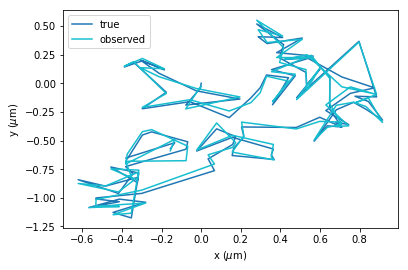

In [103]:
df1 = plot_2D_ex_traj(0.01, 1)

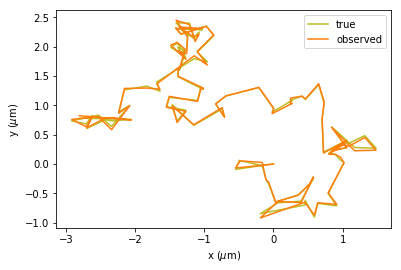

In [104]:
df2 = plot_2D_ex_traj(0.02, 2)

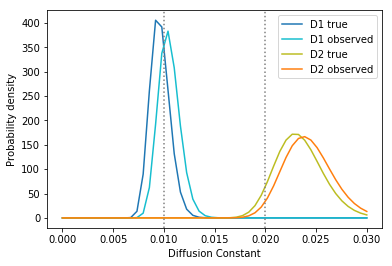

In [105]:
draw_all_posteriors(df1, df2)